# Stock Trades by Members of the US House of Representatives

* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    - Can you predict the party affiliation of a representative from their stock trades?
    - Can you predict the geographic region that the representative comes from using their stock trades? E.g., west coast, east coast, south, etc.
    * Can you predict whether a particular trade is a BUY or SELL?

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
In this notebook, we predict the party affiliation of a representative from their stock trades. In order to do so, we collected data from https://housestockwatcher.com/api and combined it with https://www.kaggle.com/datasets/unanimad/us-election-2020 in order to find the party membership of the candidates. Overall, we had the four columns 'transaction_date', 'amount', 'ticker' and 'type' at our disposition in order to predict the party membership of associated politician. Our assumption for this to work is that democrats, on average, trade differently than republicans.

### Baseline Model
The baseline model will be a DecisionTreeClassifier trained on the either raw or One-Hot-encoded features. On a test dataset being 20% the size of the total data and 100 iterations, the baseline model attains an average root mean squared error of 0.79. This gives us a value on which we can base the benchmarks of the further analysis.

### Final Model
In order to improve the baseline model, we took various measures:
- Transform the 'amount' variable into an integer and standardize it based on the transaction type
- Put the 'transaction_date' into One-Hot-encoded bins. Divide the 3 years into 12 bins in order to represent business quarters.
- Use the support vector classifier SVC and systematically adapt the hyperparameter C to yield the best results.

### Fairness Evaluation
- We realised that the dataset contains more transactions effected by republicans which leads the model to predict the label "REP" with  for a transaction

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from fuzzywuzzy import fuzz
import fuzzywuzzy.process as fwp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def merge_parties(path_cand='./data/house_candidate.csv', path_trans='./data/all_transactions.csv'):
    data_candidates = pd.read_csv(path_cand)
    data_candidates["candidate"] = data_candidates["candidate"].str.lower()
    data_transactions = pd.read_csv(path_trans)
    data_transactions["representative"] = data_transactions["representative"]\
        .str.lower()\
        .str.replace("hon. ", "", regex=False)
    data_transactions["amount"] = data_transactions["amount"]\
        .str.replace("$", "", regex=False)\
        .str.replace(" ", "", regex=False)\
        .str.replace(",", "", regex=False)\
        .str.split("-")\
        .apply(lambda x : np.floor(pd.to_numeric(pd.Series(x), errors="coerce").mean()))
    data_transactions.loc[data_transactions["ticker"] == "--", "ticker"] = np.NaN
    choices = data_transactions["representative"].unique().tolist()
    data_candidates["representative"] = data_candidates["candidate"].apply(lambda x : fmatch(x, choices))
    data_candidates = data_candidates[["representative", "party"]].drop_duplicates().dropna()
    data_candidates = remove_duplicate_name(data_candidates)
    data_transactions = data_transactions[["transaction_date", "ticker", "type", "amount", "representative"]]\
        .drop_duplicates()
    return data_transactions.merge(data_candidates, how="left", left_on="representative", right_on="representative")

def fmatch(row, choices):
    choice = fwp.extractOne(row, choices, scorer=fuzz.token_set_ratio, score_cutoff=81)
    return np.NaN if choice is None else choice[0]

def count_names(search, list):
    return len(list[list["representative"] == search]) if not search == np.NaN else np.NaN

def remove_duplicate_name(df):
    new_df = df.copy()
    unique_names = pd.DataFrame(new_df["representative"]
                                .apply(lambda x : x if count_names(x, new_df) == 1 else np.NaN).dropna())
    return unique_names.merge(df, how="left", left_on="representative", right_on="representative", suffixes=("l", "r"))

In [4]:
data = merge_parties()
data.head(10)

,transaction_date,ticker,type,amount,representative,party
0,2021-09-27,BP,purchase,8000.0,virginia foxx,REP
1,2021-09-13,XOM,purchase,8000.0,virginia foxx,REP
2,2021-09-10,ILPT,purchase,32500.0,virginia foxx,REP
3,2021-09-28,PM,purchase,32500.0,virginia foxx,REP
4,2021-09-17,BLK,sale_partial,8000.0,alan s. lowenthal,DEM
5,2021-12-01,AXP,purchase,8000.0,aston donald mceachin,DEM
6,2021-11-30,KPLTW,purchase,8000.0,austin scott,REP
7,2021-11-18,AMD,sale_full,75000.0,thomas suozzi,DEM
8,2021-11-18,AAPL,sale_full,75000.0,thomas suozzi,DEM
9,2021-11-24,MSFT,purchase,75000.0,thomas suozzi,DEM


In [33]:
stocks = merge_parties()
stocks = stocks.dropna()
stocks = stocks[stocks["transaction_date"].str[:5].apply(lambda x: x in ["2019-", "2020-", "2021-", "2022-"])]

X = stocks[['type', 'amount', 'transaction_date', 'ticker']]
y = stocks[["party"]]

### Baseline Model

In [7]:
stocks = merge_parties().dropna()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem

year_prefix_hotencode = Pipeline([
    ("get-year", FunctionTransformer(lambda x : pd.DataFrame(x["transaction_date"].str[:4]))),
    ("onehot", OneHotEncoder(handle_unknown='ignore')),
])

preproc = ColumnTransformer(
transformers=[
    ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type", "ticker"]),
    ('year', year_prefix_hotencode, ["transaction_date"])
]
)
pl = Pipeline([
    ('preproc', preproc),
    ('embedding', DecisionTreeClassifier()),
])

pl.fit(X_train, y_train["party"])
(pl.score(X_train, y_train["party"]), pl.score(X_test, y_test["party"]))

(0.9385702311100467, 0.8002873563218391)

<AxesSubplot:ylabel='Frequency'>

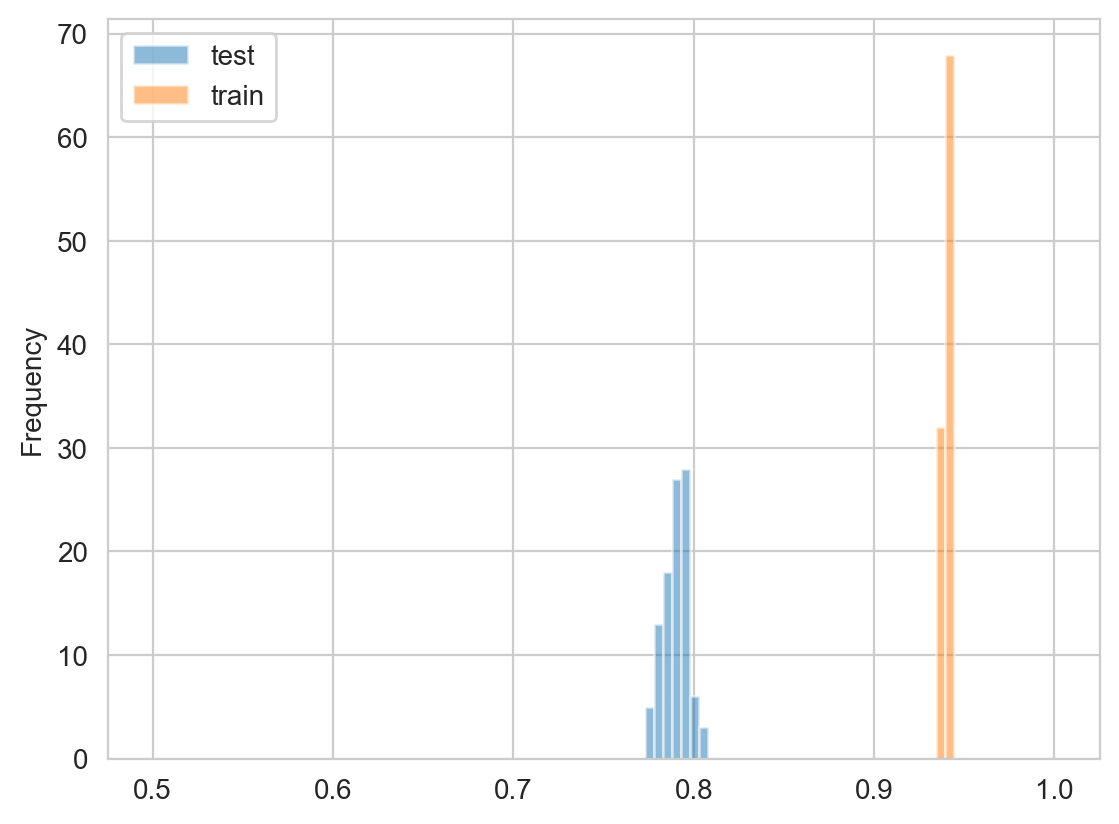

In [37]:
res = {"test":[],"train":[]}
for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(stocks[['type', 'amount', 'transaction_date', 'ticker']],
                                                        stocks[['party']])
    pl.fit(X_train, y_train["party"])
    res["test"].append(pl.score(X_test, y_test["party"]))
    res["train"].append(pl.score(X_train, y_train["party"]))

pd.DataFrame(res).plot.hist(bins=np.linspace(0.5, 1, 100),alpha=0.5)

In [38]:
res = {"n":[],"test":[],"train":[]}
for n in range(1,100,5):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', DecisionTreeClassifier(max_depth=n)),
    ])

    run = {"test":[],"train":[]}
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(stocks[['type', 'amount', 'transaction_date', 'ticker']],
                                                        stocks[['party']], random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

    mns = pd.DataFrame(run).mean()
    res["n"].append(n)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])

df = pd.DataFrame(res)
df.set_index("n").plot()

NameError: name 'X' is not defined

## Final Model

- using SVC (State Vector Machine)

0


<AxesSubplot:>

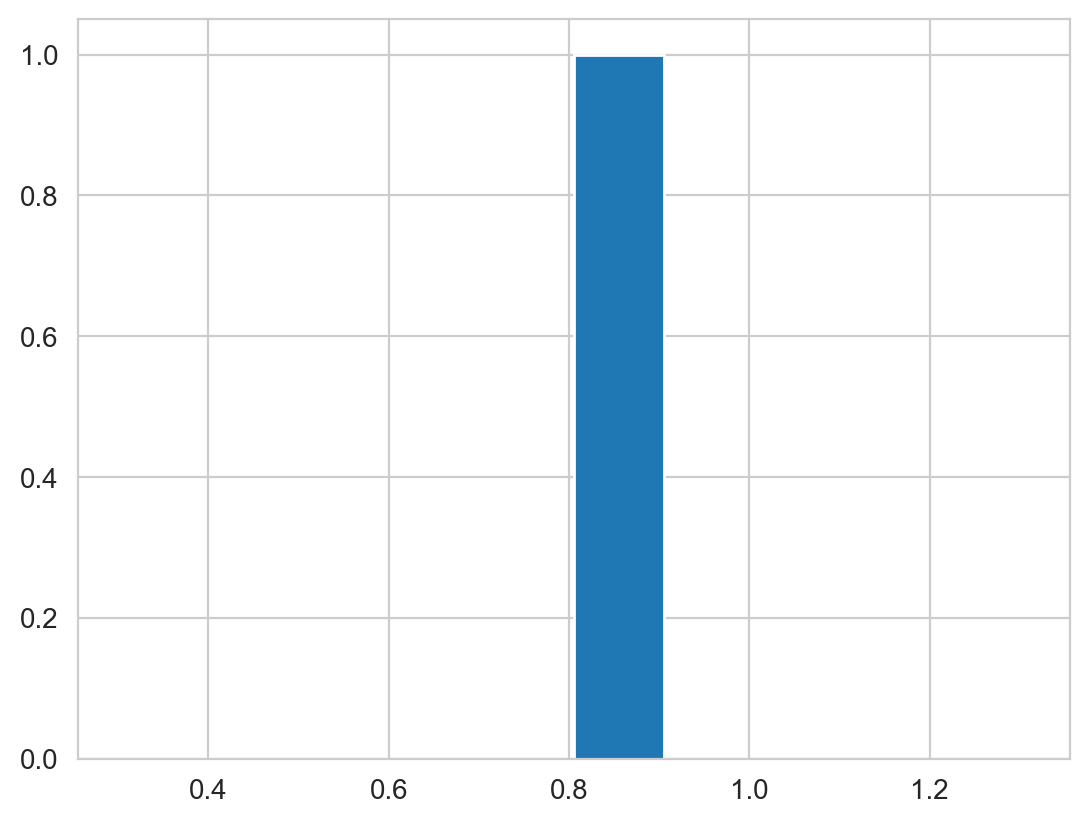

In [110]:
from sklearn.preprocessing import KBinsDiscretizer
from stdscaler import StdScalerByGroup
import time, datetime
year_prefix_hotencode = Pipeline([
    ("transform-date-to-int", FunctionTransformer(lambda x : x["transaction_date"].apply(lambda x : time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple())))),
    ("to-2d-df", FunctionTransformer(lambda x : pd.DataFrame(x))),
    ("bins", KBinsDiscretizer()),
])
preproc = ColumnTransformer(
transformers=[
    ('amount', OneHotEncoder(handle_unknown='ignore'), ["amount", "type", "ticker"]),
    ('year', year_prefix_hotencode, ["transaction_date"]),
    ('stdscalerbygroup', StdScalerByGroup(), ["type", "amount"])
]
)
pl = Pipeline([
    ('preproc', preproc),
    ('embedding', SVC(C=3, class_weight={"REP":0.65, "DEM": 0.34})),
])
res = {}
for x in range(1):
    print(x)
    X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel())
    pl.fit(X_train, y_train)
    res.append(pl.score(X_test, y_test))
pd.Series(res).hist()

In [104]:
y.value_counts()/len(y)

party
DEM      0.669337
REP      0.330483
LIB      0.000180
dtype: float64

In [92]:
pd.Series(pl.predict(X_test)).value_counts()

DEM    1741
REP    1036
dtype: int64

In [86]:
pd.Series(pl.predict(X_test)).value_counts()

DEM    2359
REP     418
dtype: int64

In [60]:
preproc.fit(X)
data = preproc.transform(X)
df = pd.DataFrame(data.toarray())
df.isna()

/Users/jamo/code/stock-prediction/stdscaler.py:58: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in ser.iteritems():
/Users/jamo/code/stock-prediction/stdscaler.py:58: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in ser.iteritems():


,0,1,2,3,4,5,6,7,8,9,...,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11103,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11104,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11105,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11106,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:>

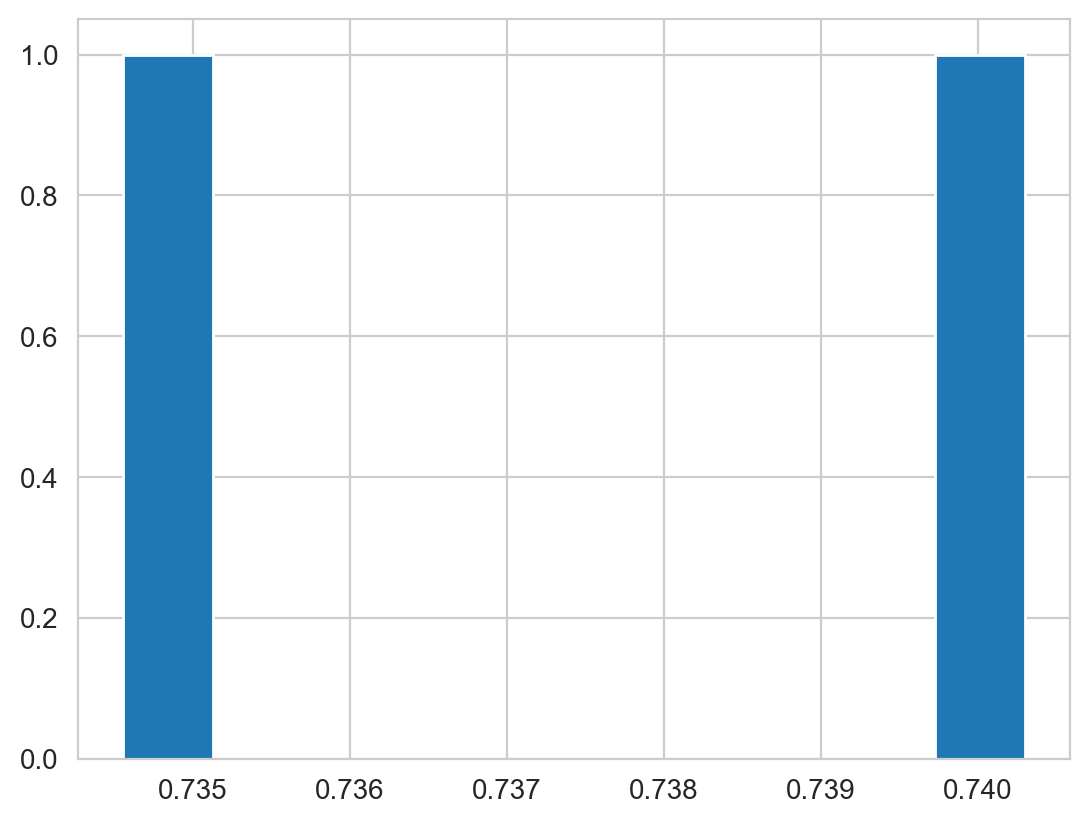

In [52]:
from sklearn.svm import LinearSVC

pl = Pipeline([
    ('preproc', preproc),
    ('Nystroem', Nystroem()),
    ('embedding', LinearSVC(C=3, class_weight={"REP": 0.66, "DEM": 0.33})),
])

stocks["party"].value_counts()

res = []
for _ in range(2):
    wo_bias = stocks #pd.concat([stocks[stocks["party"] == "DEM"][:3500], stocks[stocks["party"] == "REP"][:3500]])
    X_train, X_test, y_train, y_test = train_test_split(wo_bias.drop("party", axis = 1), wo_bias["party"])
    pl.fit(X_train, y_train)
    pl.score(X_test, y_test)

    X_test["party"] = y_test

    res.append(pl.score(stocks.drop(X_train.index).drop("party", axis = 1), stocks.drop(X_train.index)["party"]))
pd.Series(res).hist()

## Hyperparameter search

In [ ]:
res = {"n":[],"test":[],"train":[]}
for n in np.arange(0.5,8,0.3):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', SVC(C=n)),
    ])

    run = {"test":[],"train":[]}
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

    mns = pd.DataFrame(run).mean()
    res["n"].append(n)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])

df = pd.DataFrame(res)
df.set_index("n").plot()

<AxesSubplot: xlabel='n'>

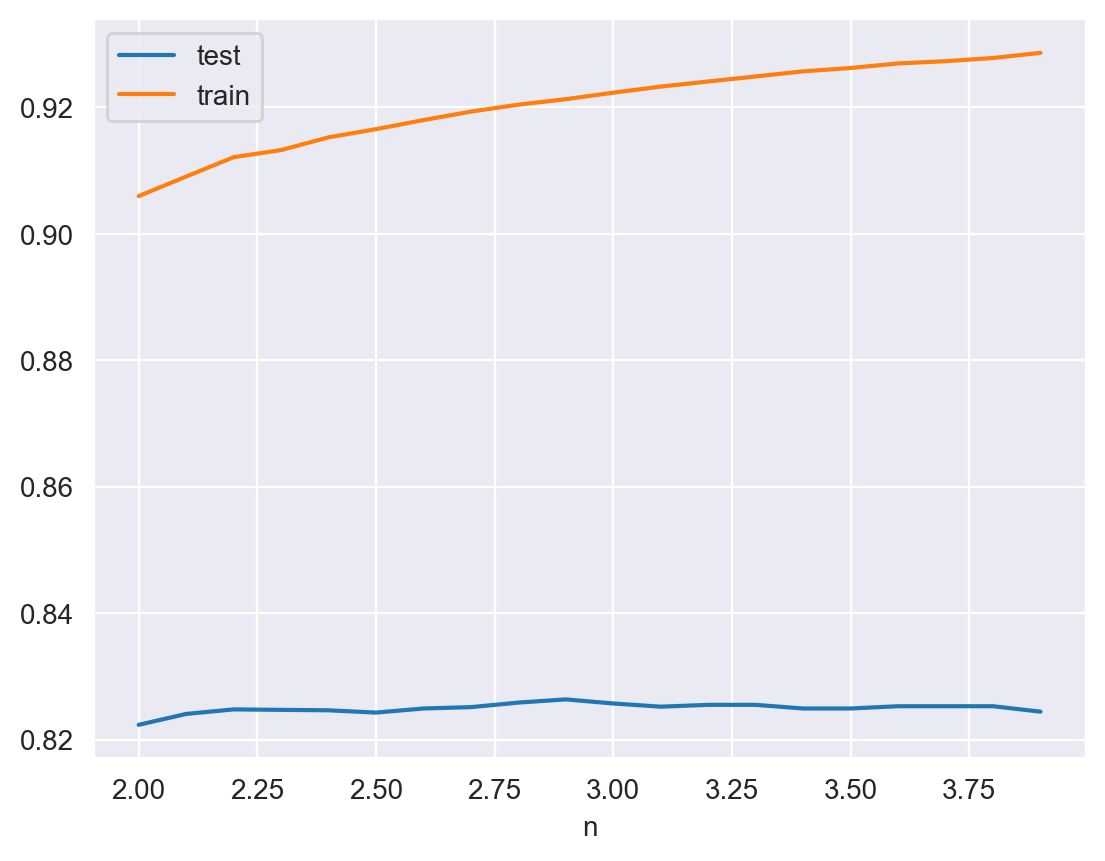

In [54]:
res = {"n":[],"test":[],"train":[]}
for n in np.arange(2,4,0.1):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', SVC(C=n)),
    ])


    run = {"test":[],"train":[]}
    for i in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

    mns = pd.DataFrame(run).mean()
    res["n"].append(n)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])

df = pd.DataFrame(res)
df.set_index("n").plot()

<AxesSubplot: ylabel='Frequency'>

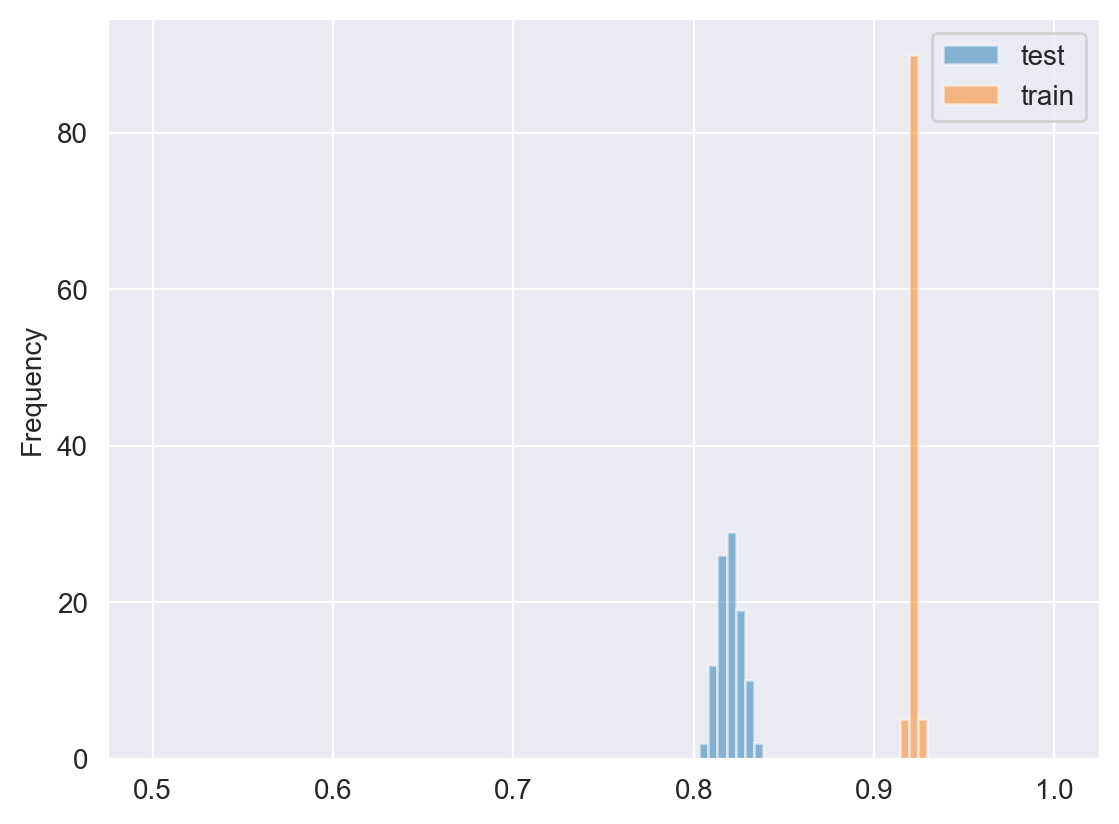

In [62]:
res = {"test":[],"train":[]}
for _ in range(100):
    pl = Pipeline([
        ('preproc', preproc),
        ('model', SVC(C=2.9)),
    ])
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pl.fit(X_train, y_train["party"])
    res["test"].append(pl.score(X_test, y_test["party"]))
    res["train"].append(pl.score(X_train, y_train["party"]))
pd.DataFrame(res).plot.hist(bins=np.linspace(0.5, 1, 100),alpha=0.5)

### Fairness Evaluation

In [ ]:
stocks["party"].dropna().value_counts()/len(stocks["party"].dropna())

In [42]:
stocks.drop(X_train.index)["party"].value_counts()

DEM    4789
REP    1094
LIB       2
Name: party, dtype: int64

In [111]:
from sklearn.metrics import confusion_matrix
df = pd.DataFrame(confusion_matrix(stocks.drop(X_train.index)["party"],pl.predict(stocks.drop(X_train.index).drop("party", axis = 1))))
df.columns = ["DEM_pred", "LIB_pred", "REP_pred"] #
df.index = ["DEM_ground", "LIB_ground", "REP_ground"] #
df

,DEM_pred,LIB_pred,REP_pred
DEM_ground,1560,0,302
LIB_ground,1,0,0
REP_ground,237,0,677


In [112]:
dem_recall = df["DEM_pred"]["DEM_ground"]/(df["DEM_pred"]["DEM_ground"]+df["REP_pred"]["DEM_ground"])
dem_recall

0.8378088077336198

In [113]:
rep_recall = df["REP_pred"]["REP_ground"]/(df["REP_pred"]["REP_ground"]+df["DEM_pred"]["REP_ground"])
rep_recall

0.7407002188183808

In [ ]:
res = {"n":[],"test":[],"train":[]}
for p in np.arange(0.1,1.0,0.05):
    pl = Pipeline([
        ('preproc', preproc),
        ('embedding', SGDClassifier(C=p)),
    ])

    run = {"test":[],"train":[]}
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=i)
        pl.fit(X_train, y_train["party"])
        run["test"].append(pl.score(X_test, y_test["party"]))
        run["train"].append(pl.score(X_train, y_train["party"]))

    mns = pd.DataFrame(run).mean()
    res["n"].append(n)
    res["test"].append(mns.loc["test"])
    res["train"].append(mns.loc["train"])

df = pd.DataFrame(res)
df.set_index("n").plot()

<AxesSubplot: >

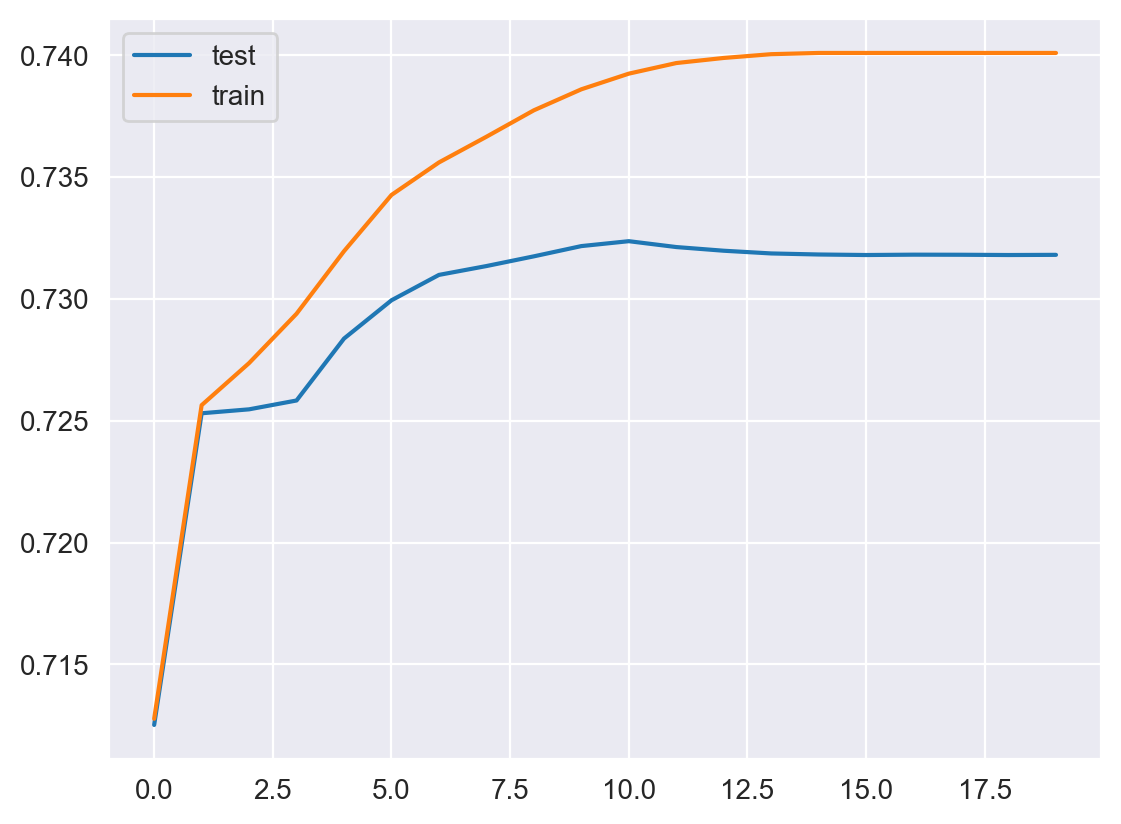